# Exploring 5 Years of European Football

# Intro

In this notebook we will explore modern metrics in football (xG, xGA and xPTS) and its' influence in sport analytics.

* **Expected Goals (xG)** - measures the quality of a shot based on several variables such as assist type, shot angle and distance from goal, whether it was a headed shot and whether it was defined as a big chance.

* **Expected Assits (xGA)** - measures the likelihood that a given pass will become a goal assist. It considers several factors including the type of pass, pass end-point and length of the pass.

* **Expected Points (xPTS)** - measures the likelihood of a certaing game to bring points to the team.

These metrics let us look much deeper into football statistics and understand performance of players and teams in general and realize the role of luck and skill in it. Disclaimer: they are both important.

The process of data collection for this notebook is described in this Kaggle kernel: [Web Scraping Football Statistics](https://www.kaggle.com/slehkyi/web-scraping-football-statistics-2014-now)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import warnings

from IPython.core.display import display, HTML

# import plotly 
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.tools as tls

# configure things
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format  
pd.options.display.max_columns = 999

py.init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

%matplotlib inline
sns.set()

# !pip install plotly --upgrade

In [2]:
# # func to make plotly work in Collaboratory (not necessary on Kaggle)
# def configure_plotly_browser_state():
#   import IPython
#   display(IPython.core.display.HTML('''
# <script src="/static/components/requirejs/require.js"></script>
# <script>
#   requirejs.config({
#     paths: {
#       base: 'static/base',
#       plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
#     },
#   });
# </script>
# '''))

# Import Data and Visual EDA

In [3]:
# import os
# for dirname, _, filenames in os.walk('../input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

df = pd.read_csv('../input/extended-football-stats-for-european-leagues-xg/understat.com.csv')
df = df.rename(index=int, columns={'Unnamed: 0': 'league', 'Unnamed: 1': 'year'}) 
df.head()

,league,year,position,team,matches,wins,draws,loses,scored,missed,pts,xG,xG_diff,npxG,xGA,xGA_diff,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff
0,Bundesliga,2014,1,Bayern Munich,34,25,4,5,80,18,79,66.21,-13.79,61.66,21.94,3.94,20.42,41.24,5.76,25.02,388,83,73.61,-5.39
1,Bundesliga,2014,2,Wolfsburg,34,20,9,5,72,38,69,58.35,-13.65,55.32,38.82,0.82,36.42,18.90,9.14,10.29,172,164,59.95,-9.05
2,Bundesliga,2014,3,Borussia M.Gladbach,34,19,9,6,53,26,66,51.74,-1.26,49.47,36.34,10.34,33.31,16.16,12.75,12.78,221,198,57.01,-8.99
3,Bundesliga,2014,4,Bayer Leverkusen,34,17,10,7,62,37,61,49.16,-12.84,48.40,34.72,-2.28,30.17,18.22,5.69,7.35,246,108,55.34,-5.66
4,Bundesliga,2014,5,Augsburg,34,15,4,15,43,43,49,43.91,0.91,37.72,46.66,3.66,43.63,-5.91,7.63,10.40,134,221,45.50,-3.50


In the next visualization we will check how many teams from each league were in top 4 during last 5 years. It can give us some info about stability of top teams from different countries.

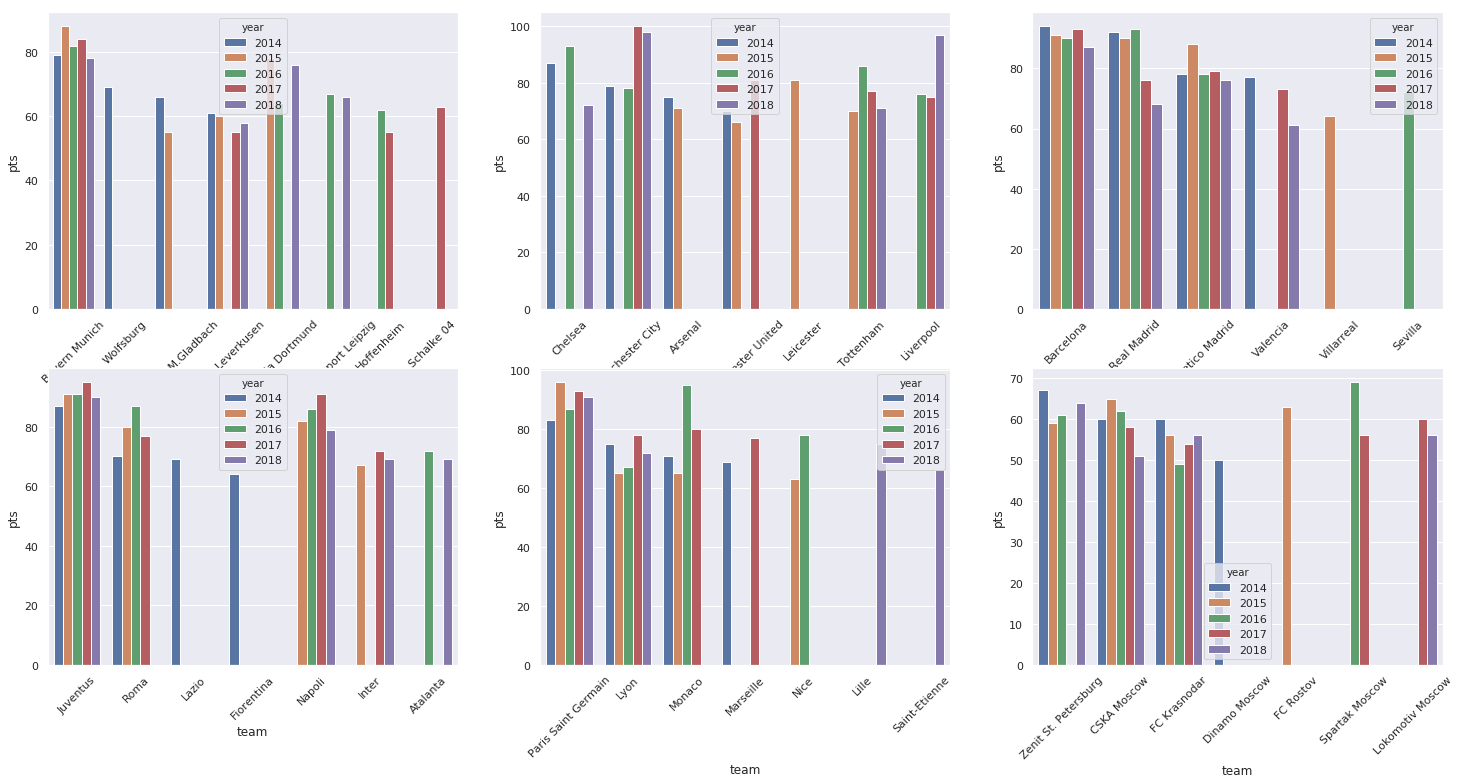

In [4]:
f = plt.figure(figsize=(25,12))
ax = f.add_subplot(2,3,1)
plt.xticks(rotation=45)
sns.barplot(x='team', y='pts', hue='year', data=df[(df['league'] == 'Bundesliga') & (df['position'] <= 4)], ax=ax)
ax = f.add_subplot(2,3,2)
plt.xticks(rotation=45)
sns.barplot(x='team', y='pts', hue='year', data=df[(df['league'] == 'EPL') & (df['position'] <= 4)], ax=ax)
ax = f.add_subplot(2,3,3)
plt.xticks(rotation=45)
sns.barplot(x='team', y='pts', hue='year', data=df[(df['league'] == 'La_liga') & (df['position'] <= 4)], ax=ax)
ax = f.add_subplot(2,3,4)
plt.xticks(rotation=45)
sns.barplot(x='team', y='pts', hue='year', data=df[(df['league'] == 'Serie_A') & (df['position'] <= 4)], ax=ax)
ax = f.add_subplot(2,3,5)
plt.xticks(rotation=45)
sns.barplot(x='team', y='pts', hue='year', data=df[(df['league'] == 'Ligue_1') & (df['position'] <= 4)], ax=ax)
ax = f.add_subplot(2,3,6)
plt.xticks(rotation=45)
sns.barplot(x='team', y='pts', hue='year', data=df[(df['league'] == 'RFPL') & (df['position'] <= 4)], ax=ax)

As we can see from these bar charts, there are teams that in last 5 years were in top 4 only once, which means it is not something common, which means if we dig deeper, we can find that there is a factor of luck that might have played in favour to these teams. It's just a theory, so let's look closer to those outliers.

The teams that were in top 4 only once during last 5 seasons are:

*  Wolfsburg (2014) and Schalke 04 (2017) from Bundesliga
*  Leicester (2015) from EPL
*  Villareal (2015) and Sevilla (2016) from La Liga
*  Lazio (2014) and Fiorentina (2014) from Serie A
*  Lille (2018) and Saint-Etienne (2018) from Ligue 1
*  FC Rostov (2015) and Dinamo Moscow (2014) from RFPL

Let's save these teams.

In [5]:
# Removing unnecessary for our analysis columns 
df_xg = df[['league', 'year', 'position', 'team', 'scored', 'xG', 'xG_diff', 'missed', 'xGA', 'xGA_diff', 'pts', 'xpts', 'xpts_diff']]

outlier_teams = ['Wolfsburg', 'Schalke 04', 'Leicester', 'Villareal', 'Sevilla', 'Lazio', 'Fiorentina', 'Lille', 'Saint-Etienne', 'FC Rostov', 'Dinamo Moscow']

In [6]:
# Checking if getting the first place requires fenomenal execution
first_place = df_xg[df_xg['position'] == 1]

# Get list of leagues
leagues = df['league'].drop_duplicates()
leagues = leagues.tolist()

# Get list of years
years = df['year'].drop_duplicates()
years = years.tolist()

# Understanding How Winners Win

In this section we will try to find some patterns that can help us understand what are some of the ingredients of the victory soup :D. Starting with Bundesliga.

## Bundesliga

In [7]:
first_place[first_place['league'] == 'Bundesliga']

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
0,Bundesliga,2014,1,Bayern Munich,80,66.21,-13.79,18,21.94,3.94,79,73.61,-5.39
18,Bundesliga,2015,1,Bayern Munich,80,77.04,-2.96,17,20.79,3.79,88,77.97,-10.03
36,Bundesliga,2016,1,Bayern Munich,89,73.91,-15.09,22,27.04,5.04,82,73.76,-8.24
54,Bundesliga,2017,1,Bayern Munich,92,76.55,-15.45,28,30.64,2.64,84,73.52,-10.48
72,Bundesliga,2018,1,Bayern Munich,88,92.24,4.24,32,27.41,-4.59,78,82.00,4.00


In [8]:
pts = go.Bar(x = years, y = first_place['pts'][first_place['league'] == 'Bundesliga'], name = 'PTS')
xpts = go.Bar(x = years, y = first_place['xpts'][first_place['league'] == 'Bundesliga'], name = 'Expected PTS')

data = [pts, xpts]

layout = go.Layout(
    barmode='group',
    title="Comparing Actual and Expected Points for Winner Team in Bundesliga",
    xaxis={'title': 'Year'},
    yaxis={'title': "Points",
    }
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

By looking at the table and barchart we see that Bayern every year got more points that they should have, they scored more than expected and missed less than expected (except for 2018, which didn't break their plan of winning the season, but it gives some hints that Bayern played worse this year, although the competitors didn't take advantage of it). 

In [9]:
# and from this table we see that Bayern dominates here totally, even when they do not play well
df_xg[(df_xg['position'] <= 2) & (df_xg['league'] == 'Bundesliga')].sort_values(by=['year','xpts'], ascending=False)

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
72,Bundesliga,2018,1,Bayern Munich,88,92.24,4.24,32,27.41,-4.59,78,82.00,4.00
73,Bundesliga,2018,2,Borussia Dortmund,81,64.99,-16.01,44,42.88,-1.12,76,62.85,-13.15
54,Bundesliga,2017,1,Bayern Munich,92,76.55,-15.45,28,30.64,2.64,84,73.52,-10.48
55,Bundesliga,2017,2,Schalke 04,53,46.83,-6.17,37,39.42,2.42,63,51.69,-11.31
36,Bundesliga,2016,1,Bayern Munich,89,73.91,-15.09,22,27.04,5.04,82,73.76,-8.24
37,Bundesliga,2016,2,RasenBallsport Leipzig,66,55.09,-10.91,39,40.06,1.06,67,59.54,-7.46
18,Bundesliga,2015,1,Bayern Munich,80,77.04,-2.96,17,20.79,3.79,88,77.97,-10.03
19,Bundesliga,2015,2,Borussia Dortmund,82,83.41,1.41,34,29.18,-4.82,78,76.58,-1.42
0,Bundesliga,2014,1,Bayern Munich,80,66.21,-13.79,18,21.94,3.94,79,73.61,-5.39
1,Bundesliga,2014,2,Wolfsburg,72,58.35,-13.65,38,38.82,0.82,69,59.95,-9.05


## La Liga

In [10]:
first_place[first_place['league'] == 'La_liga']

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
190,La_liga,2014,1,Barcelona,110,102.98,-7.02,21,28.44,7.44,94,94.08,0.08
210,La_liga,2015,1,Barcelona,112,113.60,1.60,29,34.03,5.03,91,94.38,3.38
230,La_liga,2016,1,Real Madrid,106,90.87,-15.13,41,36.86,-4.14,93,86.17,-6.83
250,La_liga,2017,1,Barcelona,99,90.49,-8.51,29,41.62,12.62,93,79.44,-13.56
270,La_liga,2018,1,Barcelona,90,83.28,-6.72,36,44.93,8.93,87,73.96,-13.04


In [11]:
pts = go.Bar(x = years, y = first_place['pts'][first_place['league'] == 'La_liga'], name = 'PTS')
xpts = go.Bar(x = years, y = first_place['xpts'][first_place['league'] == 'La_liga'], name = 'Expected PTS')

data = [pts, xpts]

layout = go.Layout(
    barmode='group',
    title="Comparing Actual and Expected Points for Winner Team in La Liga",
    xaxis={'title': 'Year'},
    yaxis={'title': "Points",
    }
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

As we can see from the chart above that in 2014 and 2015 Barcelona was creating enough moments to win the title and do not rely on personal skills or luck, from these numbers we can actually say that THE Team was playing there.

In 2016 there were lots of competition between Madrid and Barcelona and in the end Madrid got luckier / had more guts in one particular game (or Barcelona got unlucky / didn't have balls) and it was the cost of the title. I am sure that if we dig deeper that season we can find that particular match.

In 2017 and 2018 Barcelona's success was mostly tributed to actions of Lionel Messi who was scoring or making assits in situations where normal players wouldn't do that. What led to such a jump in xPTS difference. What makes me think (having the context that Real Madrid is very active on transfer market this season) can end up bad. Just subjective opinion based on numbers and watching Barcelona games. Really hope I am wrong.

In [12]:
# comparing with runner-up
df_xg[(df_xg['position'] <= 2) & (df_xg['league'] == 'La_liga')].sort_values(by=['year','xpts'], ascending=False)

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
270,La_liga,2018,1,Barcelona,90,83.28,-6.72,36,44.93,8.93,87,73.96,-13.04
271,La_liga,2018,2,Atletico Madrid,55,51.87,-3.13,29,41.43,12.43,76,59.43,-16.57
250,La_liga,2017,1,Barcelona,99,90.49,-8.51,29,41.62,12.62,93,79.44,-13.56
251,La_liga,2017,2,Atletico Madrid,58,50.29,-7.71,22,35.48,13.48,79,61.60,-17.40
231,La_liga,2016,2,Barcelona,116,93.55,-22.45,37,31.32,-5.68,90,87.95,-2.05
230,La_liga,2016,1,Real Madrid,106,90.87,-15.13,41,36.86,-4.14,93,86.17,-6.83
210,La_liga,2015,1,Barcelona,112,113.60,1.60,29,34.03,5.03,91,94.38,3.38
211,La_liga,2015,2,Real Madrid,110,90.45,-19.55,34,45.23,11.23,90,79.09,-10.91
190,La_liga,2014,1,Barcelona,110,102.98,-7.02,21,28.44,7.44,94,94.08,0.08
191,La_liga,2014,2,Real Madrid,118,95.77,-22.23,38,42.61,4.61,92,81.75,-10.25


## EPL

In [13]:
first_place[first_place['league'] == 'EPL']

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
90,EPL,2014,1,Chelsea,73,68.64,-4.36,32,31.52,-0.48,87,75.32,-11.68
110,EPL,2015,1,Leicester,68,68.42,0.42,36,45.02,9.02,81,68.94,-12.06
130,EPL,2016,1,Chelsea,85,61.80,-23.20,33,28.62,-4.38,93,75.74,-17.26
150,EPL,2017,1,Manchester City,106,91.43,-14.57,27,24.51,-2.49,100,91.09,-8.91
170,EPL,2018,1,Manchester City,95,93.72,-1.28,23,25.73,2.73,98,90.64,-7.36


In [14]:
pts = go.Bar(x = years, y = first_place['pts'][first_place['league'] == 'EPL'], name = 'PTS')
xpts = go.Bar(x = years, y = first_place['xpts'][first_place['league'] == 'EPL'], name = 'Expected PTS')

data = [pts, xpts]

layout = go.Layout(
    barmode='group',
    title="Comparing Actual and Expected Points for Winner Team in EPL",
    xaxis={'title': 'Year'},
    yaxis={'title': "Points",
    }
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In EPL we see the clear trend that tells you: "To win you have to be better than statistics". Interesting case here is Leicester story of victory in 2015: they got 12 points more than they should've and at the same time Arsenal got 6 points less of expected! This is why we love football, because such unexplicable things happen. I am not telling is total luck, but it played its' role here.

Another interesting thing is Manchester City of 2018 - they are super stable! They scored just one goal more than expected, missed 2 less and got 7 additional points, while Liverpool fought really well, had little bit more luck on their side, but couldn't win despite being 13 points ahead of their expected.

Pep is finishing building the machine of destruction. Man City creates and converts their moments based on skill and do not rely on luck - it makes them very dangerous in the next season.

In [15]:
# comparing with runner-ups
df_xg[(df_xg['position'] <= 2) & (df_xg['league'] == 'EPL')].sort_values(by=['year','xpts'], ascending=False)

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
170,EPL,2018,1,Manchester City,95,93.72,-1.28,23,25.73,2.73,98,90.64,-7.36
171,EPL,2018,2,Liverpool,89,79.46,-9.54,22,29.15,7.15,97,83.45,-13.55
150,EPL,2017,1,Manchester City,106,91.43,-14.57,27,24.51,-2.49,100,91.09,-8.91
151,EPL,2017,2,Manchester United,68,59.04,-8.96,28,43.54,15.54,81,62.33,-18.67
130,EPL,2016,1,Chelsea,85,61.80,-23.20,33,28.62,-4.38,93,75.74,-17.26
131,EPL,2016,2,Tottenham,86,70.07,-15.93,26,33.78,7.78,86,75.37,-10.63
111,EPL,2015,2,Arsenal,65,73.53,8.53,36,33.86,-2.14,71,77.01,6.01
110,EPL,2015,1,Leicester,68,68.42,0.42,36,45.02,9.02,81,68.94,-12.06
90,EPL,2014,1,Chelsea,73,68.64,-4.36,32,31.52,-0.48,87,75.32,-11.68
91,EPL,2014,2,Manchester City,83,75.82,-7.18,38,40.50,2.50,79,73.10,-5.90


## Ligue 1

In [16]:
first_place[first_place['league'] == 'Ligue_1']

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
290,Ligue_1,2014,1,Paris Saint Germain,83,78.42,-4.58,36,28.24,-7.76,83,84.10,1.10
310,Ligue_1,2015,1,Paris Saint Germain,102,86.20,-15.80,19,24.37,5.37,96,90.27,-5.73
330,Ligue_1,2016,1,Monaco,107,76.04,-30.96,31,34.89,3.89,95,78.06,-16.94
350,Ligue_1,2017,1,Paris Saint Germain,108,89.92,-18.08,29,32.10,3.10,93,84.61,-8.39
370,Ligue_1,2018,1,Paris Saint Germain,105,95.34,-9.66,35,36.78,1.78,91,86.04,-4.96


In [17]:
pts = go.Bar(x = years, y = first_place['pts'][first_place['league'] == 'Ligue_1'], name = 'PTS')
xpts = go.Bar(x = years, y = first_place['xpts'][first_place['league'] == 'Ligue_1'], name = 'Expected PTS')

data = [pts, xpts]

layout = go.Layout(
    barmode='group',
    title="Comparing Actual and Expected Points for Winner Team in Ligue 1",
    xaxis={'title': 'Year'},
    yaxis={'title': "Points",
    }
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In French Ligue 1 we continue to see the trend "to win you have to execute 110%, because 100% is not enough". Here Paris Saint Germain dominates totally. Only in 2016 we get an outlier in the face of Monaco that scored 30 goals more than expected!!! and got almost 17 points more than expected! Luck? Quite a good piece of it. PSG was good that year, but Monaco was extraordinary. Again, we cannot claim it's pure luck or pure skill, but a perfect combination of both in right place and time.

In [18]:
# comparing with runner-ups
df_xg[(df_xg['position'] <= 2) & (df_xg['league'] == 'Ligue_1')].sort_values(by=['year','xpts'], ascending=False)

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
370,Ligue_1,2018,1,Paris Saint Germain,105,95.34,-9.66,35,36.78,1.78,91,86.04,-4.96
371,Ligue_1,2018,2,Lille,68,60.01,-7.99,33,39.85,6.85,75,67.02,-7.98
350,Ligue_1,2017,1,Paris Saint Germain,108,89.92,-18.08,29,32.10,3.10,93,84.61,-8.39
351,Ligue_1,2017,2,Monaco,85,62.41,-22.59,45,45.27,0.27,80,65.15,-14.85
331,Ligue_1,2016,2,Paris Saint Germain,83,82.16,-0.84,27,24.25,-2.75,87,87.22,0.22
330,Ligue_1,2016,1,Monaco,107,76.04,-30.96,31,34.89,3.89,95,78.06,-16.94
310,Ligue_1,2015,1,Paris Saint Germain,102,86.20,-15.80,19,24.37,5.37,96,90.27,-5.73
311,Ligue_1,2015,2,Lyon,67,63.01,-3.99,43,38.01,-4.99,65,68.69,3.69
290,Ligue_1,2014,1,Paris Saint Germain,83,78.42,-4.58,36,28.24,-7.76,83,84.10,1.10
291,Ligue_1,2014,2,Lyon,72,62.85,-9.15,33,41.71,8.71,75,65.62,-9.38


## Serie A

In [19]:
first_place[first_place['league'] == 'Serie_A']

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
470,Serie_A,2014,1,Juventus,72,59.08,-12.92,24,29.13,5.13,87,74.79,-12.21
490,Serie_A,2015,1,Juventus,75,62.99,-12.01,20,23.00,3.00,91,78.74,-12.26
510,Serie_A,2016,1,Juventus,77,68.74,-8.26,27,23.60,-3.40,91,82.86,-8.14
530,Serie_A,2017,1,Juventus,86,59.23,-26.77,24,28.58,4.58,95,73.51,-21.49
550,Serie_A,2018,1,Juventus,70,64.53,-5.47,30,35.03,5.03,90,70.93,-19.07


In [20]:
pts = go.Bar(x = years, y = first_place['pts'][first_place['league'] == 'Serie_A'], name = 'PTS')
xpts = go.Bar(x = years, y = first_place['xpts'][first_place['league'] == 'Serie_A'], name = 'Expecetd PTS')

data = [pts, xpts]

layout = go.Layout(
    barmode='group',
    title="Comparing Actual and Expected Points for Winner Team in Serie A",
    xaxis={'title': 'Year'},
    yaxis={'title': "Points",
    }
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In Italian Serie A Juventus is dominating 8 years in a row although cannot show any major success in Champions League. I think by checking this chart and numbers we can understand that Juve doesn't have strong enough competiton inside the country and gets lots of "lucky" points, which again derives from multiple factors and we can see that Napoli outperformed Juventus by xPTS twice, but it is a real life and in, for example 2017, Juve was crazy and scored additional 26 goals (or created goals from nowhere), while Napoli missed 3 more than expected (due to error of goalkeeper or maybe excelence of some team in 1 or 2 particular matches). As with the situation in La Liga when Real Madrid became a champion I am sure we can find 1 or 2 games that was key that year.

Details matter in football. You see, one error here, one woodwork there and you've lost the title.

In [21]:
# comparing to runner-ups
df_xg[(df_xg['position'] <= 2) & (df_xg['league'] == 'Serie_A')].sort_values(by=['year','xpts'], ascending=False)

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
551,Serie_A,2018,2,Napoli,74,68.24,-5.76,36,36.50,0.50,79,74.45,-4.55
550,Serie_A,2018,1,Juventus,70,64.53,-5.47,30,35.03,5.03,90,70.93,-19.07
531,Serie_A,2017,2,Napoli,77,70.45,-6.55,29,25.27,-3.73,91,82.23,-8.77
530,Serie_A,2017,1,Juventus,86,59.23,-26.77,24,28.58,4.58,95,73.51,-21.49
510,Serie_A,2016,1,Juventus,77,68.74,-8.26,27,23.60,-3.40,91,82.86,-8.14
511,Serie_A,2016,2,Roma,90,83.00,-7.00,38,41.08,3.08,87,77.39,-9.61
491,Serie_A,2015,2,Napoli,80,69.53,-10.47,32,26.69,-5.31,82,79.07,-2.93
490,Serie_A,2015,1,Juventus,75,62.99,-12.01,20,23.00,3.00,91,78.74,-12.26
470,Serie_A,2014,1,Juventus,72,59.08,-12.92,24,29.13,5.13,87,74.79,-12.21
471,Serie_A,2014,2,Roma,54,50.85,-3.15,31,36.79,5.79,70,62.16,-7.84


## RFPL

In [22]:
first_place[first_place['league'] == 'RFPL']

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
390,RFPL,2014,1,Zenit St. Petersburg,58,50.52,-7.48,17,16.84,-0.16,67,63.84,-3.16
406,RFPL,2015,1,CSKA Moscow,51,49.47,-1.53,25,25.26,0.26,65,58.35,-6.65
422,RFPL,2016,1,Spartak Moscow,46,35.68,-10.32,27,30.31,3.31,69,45.00,-24.00
438,RFPL,2017,1,Lokomotiv Moscow,41,36.42,-4.58,21,23.29,2.29,60,50.79,-9.21
454,RFPL,2018,1,Zenit St. Petersburg,57,49.46,-7.54,29,27.27,-1.73,64,56.47,-7.53


In [23]:
pts = go.Bar(x = years, y = first_place['pts'][first_place['league'] == 'RFPL'], name = 'PTS')
xpts = go.Bar(x = years, y = first_place['xpts'][first_place['league'] == 'RFPL'], name = 'Expected PTS')

data = [pts, xpts]

layout = go.Layout(
    barmode='group',
    title="Comparing Actual and Expected Points for Winner Team in RFPL",
    xaxis={'title': 'Year'},
    yaxis={'title': "Points",
    }
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

I do not follow Russian Premier League, so just by coldly looking at data we see the same pattern as scoring more than you deserve and also intersting situation with CSKA Moscow from 2015 to 2017. During these years these guys were good, but converted their advantages only once, the others two - if you do not convert, you get punished or your main competitor just converts better. 

There is no justice in football :D. Although, I believe with VAR the numbers will become more stable in next seasons. Because one of the reasons of those additional goals and points are errors of arbiters.

In [24]:
# comparing to runner-ups
df_xg[(df_xg['position'] <= 2) & (df_xg['league'] == 'RFPL')].sort_values(by=['year','xpts'], ascending=False)

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
454,RFPL,2018,1,Zenit St. Petersburg,57,49.46,-7.54,29,27.27,-1.73,64,56.47,-7.53
455,RFPL,2018,2,Lokomotiv Moscow,45,42.25,-2.75,28,30.12,2.12,56,50.58,-5.42
439,RFPL,2017,2,CSKA Moscow,49,45.71,-3.29,23,26.55,3.55,58,53.66,-4.34
438,RFPL,2017,1,Lokomotiv Moscow,41,36.42,-4.58,21,23.29,2.29,60,50.79,-9.21
423,RFPL,2016,2,CSKA Moscow,47,37.07,-9.93,15,19.62,4.62,62,54.32,-7.68
422,RFPL,2016,1,Spartak Moscow,46,35.68,-10.32,27,30.31,3.31,69,45.00,-24.00
406,RFPL,2015,1,CSKA Moscow,51,49.47,-1.53,25,25.26,0.26,65,58.35,-6.65
407,RFPL,2015,2,FC Rostov,41,37.23,-3.77,20,27.33,7.33,63,47.24,-15.76
390,RFPL,2014,1,Zenit St. Petersburg,58,50.52,-7.48,17,16.84,-0.16,67,63.84,-3.16
391,RFPL,2014,2,CSKA Moscow,67,51.02,-15.98,27,28.80,1.80,60,54.56,-5.44


# Statistical Overview

As there are 6 leagues with different teams and stats, I decided to focus on one in the beginning to test different approaches and then replicate the final analysis model on other 5. And as I watch mostly La Liga I will start with this competiton as I know the most about it.

In [25]:
# Creating separate DataFrames per each league
laliga = df_xg[df_xg['league'] == 'La_liga']
laliga.reset_index(inplace=True)
epl = df_xg[df_xg['league'] == 'EPL']
epl.reset_index(inplace=True)
bundesliga = df_xg[df_xg['league'] == 'Bundesliga']
bundesliga.reset_index(inplace=True)
seriea = df_xg[df_xg['league'] == 'Serie_A']
seriea.reset_index(inplace=True)
ligue1 = df_xg[df_xg['league'] == 'Ligue_1']
ligue1.reset_index(inplace=True)
rfpl = df_xg[df_xg['league'] == 'RFPL']
rfpl.reset_index(inplace=True)

In [26]:
laliga.describe()

,index,year,position,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,239.50,"2,016.00",10.50,51.77,50.98,-0.79,51.77,50.98,-0.79,52.32,52.47,0.15
std,29.01,1.42,5.80,20.26,16.49,8.11,14.36,10.13,8.24,18.13,13.77,7.79
min,190.00,"2,014.00",1.00,22.00,29.56,-22.45,18.00,27.80,-29.18,20.00,26.50,-17.40
25%,214.75,"2,015.00",5.75,40.00,40.72,-5.83,43.00,44.75,-7.44,40.50,42.50,-5.01
50%,239.50,"2,016.00",10.50,46.00,47.51,-0.06,51.00,50.83,0.05,49.00,50.65,0.61
75%,264.25,"2,017.00",15.25,57.25,54.96,5.34,62.00,58.10,5.30,61.00,58.33,5.39
max,289.00,"2,018.00",20.00,118.00,113.60,13.88,94.00,78.86,13.69,94.00,94.38,20.16


Using data from describe() method we can get some interesting insights about every league. Below is the function that helps to get those insights. 

In [27]:
def print_records_antirecords(df):
  print('Presenting some records and antirecords: \n')
  for col in df.describe().columns:
    if col not in ['index', 'year', 'position']:
      team_min = df['team'].loc[df[col] == df.describe().loc['min',col]].values[0]
      year_min = df['year'].loc[df[col] == df.describe().loc['min',col]].values[0]
      team_max = df['team'].loc[df[col] == df.describe().loc['max',col]].values[0]
      year_max = df['year'].loc[df[col] == df.describe().loc['max',col]].values[0]
      val_min = df.describe().loc['min',col]
      val_max = df.describe().loc['max',col]
      print('The lowest value of {0} had {1} in {2} and it is equal to {3:.2f}'.format(col.upper(), team_min, year_min, val_min))
      print('The highest value of {0} had {1} in {2} and it is equal to {3:.2f}'.format(col.upper(), team_max, year_max, val_max))
      print('='*100)
      
# replace laliga with any league you want
print_records_antirecords(laliga)

Presenting some records and antirecords: 

The lowest value of SCORED had Cordoba in 2014 and it is equal to 22.00
The highest value of SCORED had Real Madrid in 2014 and it is equal to 118.00
The lowest value of XG had Eibar in 2014 and it is equal to 29.56
The highest value of XG had Barcelona in 2015 and it is equal to 113.60
The lowest value of XG_DIFF had Barcelona in 2016 and it is equal to -22.45
The highest value of XG_DIFF had Las Palmas in 2017 and it is equal to 13.88
The lowest value of MISSED had Atletico Madrid in 2015 and it is equal to 18.00
The highest value of MISSED had Osasuna in 2016 and it is equal to 94.00
The lowest value of XGA had Atletico Madrid in 2015 and it is equal to 27.80
The highest value of XGA had Levante in 2018 and it is equal to 78.86
The lowest value of XGA_DIFF had Osasuna in 2016 and it is equal to -29.18
The highest value of XGA_DIFF had Valencia in 2015 and it is equal to 13.69
The lowest value of PTS had Cordoba in 2014 and it is equal to 20

In [28]:
trace0 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2014], 
    y = laliga['xG_diff'][laliga['year'] == 2014],
    name = '2014',
    mode = 'lines+markers'
)

trace1 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2015], 
    y = laliga['xG_diff'][laliga['year'] == 2015],
    name='2015',
    mode = 'lines+markers'
)

trace2 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2016], 
    y = laliga['xG_diff'][laliga['year'] == 2016],
    name='2016',
    mode = 'lines+markers'
)

trace3 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2017], 
    y = laliga['xG_diff'][laliga['year'] == 2017],
    name='2017',
    mode = 'lines+markers'
)

trace4 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2018], 
    y = laliga['xG_diff'][laliga['year'] == 2018],
    name='2018',
    mode = 'lines+markers'
)

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title="Comparing xG gap between positions",
    xaxis={'title': 'Year'},
    yaxis={'title': "xG difference",
    }
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [29]:
trace0 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2014], 
    y = laliga['xGA_diff'][laliga['year'] == 2014],
    name = '2014',
    mode = 'lines+markers'
)

trace1 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2015], 
    y = laliga['xGA_diff'][laliga['year'] == 2015],
    name='2015',
    mode = 'lines+markers'
)

trace2 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2016], 
    y = laliga['xGA_diff'][laliga['year'] == 2016],
    name='2016',
    mode = 'lines+markers'
)

trace3 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2017], 
    y = laliga['xGA_diff'][laliga['year'] == 2017],
    name='2017',
    mode = 'lines+markers'
)

trace4 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2018], 
    y = laliga['xGA_diff'][laliga['year'] == 2018],
    name='2018',
    mode = 'lines+markers'
)

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title="Comparing xGA gap between positions",
    xaxis={'title': 'Year'},
    yaxis={'title': "xGA difference",
    }
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [30]:
trace0 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2014], 
    y = laliga['xpts_diff'][laliga['year'] == 2014],
    name = '2014',
    mode = 'lines+markers'
)

trace1 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2015], 
    y = laliga['xpts_diff'][laliga['year'] == 2015],
    name='2015',
    mode = 'lines+markers'
)

trace2 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2016], 
    y = laliga['xpts_diff'][laliga['year'] == 2016],
    name='2016',
    mode = 'lines+markers'
)

trace3 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2017], 
    y = laliga['xpts_diff'][laliga['year'] == 2017],
    name='2017',
    mode = 'lines+markers'
)

trace4 = go.Scatter(
    x = laliga['position'][laliga['year'] == 2018], 
    y = laliga['xpts_diff'][laliga['year'] == 2018],
    name='2018',
    mode = 'lines+markers'
)

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title="Comparing xPTS gap between positions",
    xaxis={'title': 'Position'},
    yaxis={'title': "xPTS difference",
    }
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

From the charts above we can clearly see that top teams score more, concede less and get more points than expected. That's why these teams are top teams. And totally opposite situation with outsiders. The teams from the middleplay average. Totally logical, no huge insights here.

In [31]:
# Check mean differences
def get_diff_means(df):  
  dm = df.groupby('year')[['xG_diff', 'xGA_diff', 'xpts_diff']].mean()
  
  return dm

means = get_diff_means(laliga)
means

,xG_diff,xGA_diff,xpts_diff
year,,,
2014,-0.69,-0.69,0.12
2015,0.32,0.32,0.27
2016,-8.29,-8.29,-0.21
2017,1.07,1.07,-0.22
2018,3.64,3.64,0.81


In [32]:
# Check median differences
def get_diff_medians(df):  
  dm = df.groupby('year')[['xG_diff', 'xGA_diff', 'xpts_diff']].median()
  
  return dm

medians = get_diff_medians(laliga)
medians

,xG_diff,xGA_diff,xpts_diff
year,,,
2014,1.55,0.11,0.34
2015,1.91,-0.67,2.17
2016,-7.75,-8.29,-2.13
2017,-0.56,0.76,0.22
2018,4.95,2.50,0.96


# Outliers Detection

## Z-Score

Z-Score is the number of standard deviations from the mean a data point is. We can use it to find outliers in our dataset by assuming that |z-score| > 3 is an outlier.

In [33]:
# Getting outliers for xG using zscore
from scipy.stats import zscore
# laliga[(np.abs(zscore(laliga[['xG_diff']])) > 2.0).all(axis=1)]
df_xg[(np.abs(zscore(df_xg[['xG_diff']])) > 3.0).all(axis=1)]

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
130,EPL,2016,1,Chelsea,85,61.80,-23.20,33,28.62,-4.38,93,75.74,-17.26
191,La_liga,2014,2,Real Madrid,118,95.77,-22.23,38,42.61,4.61,92,81.75,-10.25
231,La_liga,2016,2,Barcelona,116,93.55,-22.45,37,31.32,-5.68,90,87.95,-2.05
330,Ligue_1,2016,1,Monaco,107,76.04,-30.96,31,34.89,3.89,95,78.06,-16.94
351,Ligue_1,2017,2,Monaco,85,62.41,-22.59,45,45.27,0.27,80,65.15,-14.85
530,Serie_A,2017,1,Juventus,86,59.23,-26.77,24,28.58,4.58,95,73.51,-21.49
534,Serie_A,2017,5,Lazio,89,66.51,-22.49,49,42.57,-6.43,72,66.05,-5.95


In [34]:
# outliers for xGA
# laliga[(np.abs(zscore(laliga[['xGA_diff']])) > 2.0).all(axis=1)]
df_xg[(np.abs(zscore(df_xg[['xGA_diff']])) > 3.0).all(axis=1)]

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
248,La_liga,2016,19,Osasuna,40,33.13,-6.87,94,64.82,-29.18,22,31.64,9.64


In [35]:
# Outliers for xPTS
# laliga[(np.abs(zscore(laliga[['xpts_diff']])) > 2.0).all(axis=1)]
df_xg[(np.abs(zscore(df_xg[['xpts_diff']])) > 3.0).all(axis=1)]

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
332,Ligue_1,2016,3,Nice,63,51.54,-11.46,36,50.89,14.89,78,53.47,-24.53
422,RFPL,2016,1,Spartak Moscow,46,35.68,-10.32,27,30.31,3.31,69,45.00,-24.00
529,Serie_A,2016,20,Pescara,35,43.12,8.12,83,68.41,-14.59,15,38.05,23.05
530,Serie_A,2017,1,Juventus,86,59.23,-26.77,24,28.58,4.58,95,73.51,-21.49


12 outliers in total detected with zscore. Poor Osasuna in 2016 - almost 30 not deserved goals.

As we can see from this data being in outlier space top does not yet make you win the season. But if you miss your opportunities or receive goals where you shouldn't and do that toooooo much - you deserve relegation. Losing and being average is much easier than winning.

## Interquartile Range (IQR)

IQR - is the difference between the first quartile and third quartile of a set of data. This is one way to describe the spread of a set of data. 

A commonly used rule says that a data point is an outlier if it is more than 1.5 ⋅ IQR above the third quartile or below the first quartile. Said differently, low outliers are below Q1 − 1.5 ⋅ IQR and high outliers are above Q3 + 1.5 ⋅ IQR.

Let's check it out.

In [36]:
# Trying different method of outliers detection
df_xg.describe()

,year,position,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff
count,570.00,570.00,570.00,570.00,570.00,570.00,570.00,570.00,570.00,570.00,570.00
mean,"2,016.00",10.06,48.39,46.96,-1.43,48.39,46.96,-1.43,49.78,49.94,0.16
std,1.42,5.58,17.63,14.46,6.92,13.84,11.63,6.67,17.05,13.54,7.22
min,"2,014.00",1.00,13.00,15.06,-30.96,15.00,16.84,-29.18,13.00,17.91,-24.53
25%,"2,015.00",5.00,36.00,37.29,-5.28,39.00,39.36,-6.10,38.00,40.43,-4.48
50%,"2,016.00",10.00,45.00,44.60,-1.07,49.00,47.34,-1.20,46.50,47.41,0.22
75%,"2,017.00",15.00,56.00,53.79,3.49,57.00,54.62,3.20,60.00,57.33,4.80
max,"2,018.00",20.00,118.00,113.60,18.15,94.00,78.86,15.54,100.00,94.38,23.05


In [37]:
# using Interquartile Range Method to identify outliers
# xG_diff
iqr_xG = (df_xg.describe().loc['75%','xG_diff'] - df_xg.describe().loc['25%','xG_diff']) * 1.5
upper_xG = df_xg.describe().loc['75%','xG_diff'] + iqr_xG
lower_xG = df_xg.describe().loc['25%','xG_diff'] - iqr_xG

print('IQR for xG_diff: {:.2f}'.format(iqr_xG))
print('Upper border for xG_diff: {:.2f}'.format(upper_xG))
print('Lower border for xG_diff: {:.2f}'.format(lower_xG))

outliers_xG = df_xg[(df_xg['xG_diff'] > upper_xG) | (df_xg['xG_diff'] < lower_xG)]
print('='*50)

# xGA_diff
iqr_xGA = (df_xg.describe().loc['75%','xGA_diff'] - df_xg.describe().loc['25%','xGA_diff']) * 1.5
upper_xGA = df_xg.describe().loc['75%','xGA_diff'] + iqr_xGA
lower_xGA = df_xg.describe().loc['25%','xGA_diff'] - iqr_xGA

print('IQR for xGA_diff: {:.2f}'.format(iqr_xGA))
print('Upper border for xGA_diff: {:.2f}'.format(upper_xGA))
print('Lower border for xGA_diff: {:.2f}'.format(lower_xGA))

outliers_xGA = df_xg[(df_xg['xGA_diff'] > upper_xGA) | (df_xg['xGA_diff'] < lower_xGA)]
print('='*50)

# xpts_diff
iqr_xpts = (df_xg.describe().loc['75%','xpts_diff'] - df_xg.describe().loc['25%','xpts_diff']) * 1.5
upper_xpts = df_xg.describe().loc['75%','xpts_diff'] + iqr_xpts
lower_xpts = df_xg.describe().loc['25%','xpts_diff'] - iqr_xpts

print('IQR for xPTS_diff: {:.2f}'.format(iqr_xpts))
print('Upper border for xPTS_diff: {:.2f}'.format(upper_xpts))
print('Lower border for xPTS_diff: {:.2f}'.format(lower_xpts))

outliers_xpts = df_xg[(df_xg['xpts_diff'] > upper_xpts) | (df_xg['xpts_diff'] < lower_xpts)]
print('='*50)

outliers_full = pd.concat([outliers_xG, outliers_xGA, outliers_xpts])
outliers_full = outliers_full.drop_duplicates()

IQR for xG_diff: 13.16
Upper border for xG_diff: 16.65
Lower border for xG_diff: -18.43
IQR for xGA_diff: 13.95
Upper border for xGA_diff: 17.15
Lower border for xGA_diff: -20.05
IQR for xPTS_diff: 13.93
Upper border for xPTS_diff: 18.73
Lower border for xPTS_diff: -18.41


In [38]:
# Adding ratings bottom to up to find looser in each league (different amount of teams in every league so I can't do just n-20)
max_position = df_xg.groupby('league')['position'].max()
df_xg['position_reverse'] = np.nan
outliers_full['position_reverse'] = np.nan

for i, row in df_xg.iterrows():
  df_xg.at[i, 'position_reverse'] = np.abs(row['position'] - max_position[row['league']])+1
  
for i, row in outliers_full.iterrows():
  outliers_full.at[i, 'position_reverse'] = np.abs(row['position'] - max_position[row['league']])+1

In [39]:
total_count = df_xg[(df_xg['position'] <= 4) | (df_xg['position_reverse'] <= 3)].count()[0]
outlier_count = outliers_full[(outliers_full['position'] <= 4) | (outliers_full['position_reverse'] <= 3)].count()[0]
outlier_prob = outlier_count / total_count
print('Probability of outlier in top or bottom of the final table: {:.2%}'.format(outlier_prob))

Probability of outlier in top or bottom of the final table: 8.10%


So we can say that it is very probable that every year in one of 6 leagues there will be a team that gets a ticket to Champions League or Europa Legue with the help of luck on top of their great skills or there is a looser that gets to the second division, because they cannot convert their moments.

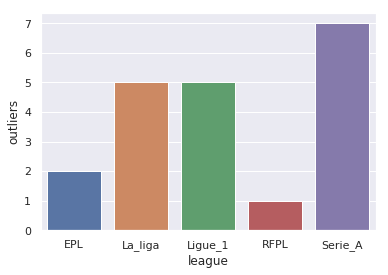

In [40]:
# 1-3 outliers among all leagues in a year
data = pd.DataFrame(outliers_full.groupby('league')['year'].count()).reset_index()
data = data.rename(index=int, columns={'year': 'outliers'})
sns.barplot(x='league', y='outliers', data=data)
# no outliers in Bundesliga

Our winners and losers with brilliant performance and brilliant underperformance

In [41]:
top_bottom = outliers_full[(outliers_full['position'] <= 4) | (outliers_full['position_reverse'] <= 3)].sort_values(by='league')
top_bottom

,league,year,position,team,scored,xG,xG_diff,missed,xGA,xGA_diff,pts,xpts,xpts_diff,position_reverse
130,EPL,2016,1,Chelsea,85,61.80,-23.20,33,28.62,-4.38,93,75.74,-17.26,20.00
151,EPL,2017,2,Manchester United,68,59.04,-8.96,28,43.54,15.54,81,62.33,-18.67,19.00
191,La_liga,2014,2,Real Madrid,118,95.77,-22.23,38,42.61,4.61,92,81.75,-10.25,19.00
211,La_liga,2015,2,Real Madrid,110,90.45,-19.55,34,45.23,11.23,90,79.09,-10.91,19.00
231,La_liga,2016,2,Barcelona,116,93.55,-22.45,37,31.32,-5.68,90,87.95,-2.05,19.00
248,La_liga,2016,19,Osasuna,40,33.13,-6.87,94,64.82,-29.18,22,31.64,9.64,2.00
267,La_liga,2017,18,Deportivo La Coruna,38,49.78,11.78,76,60.87,-15.13,29,49.16,20.16,3.00
330,Ligue_1,2016,1,Monaco,107,76.04,-30.96,31,34.89,3.89,95,78.06,-16.94,20.00
351,Ligue_1,2017,2,Monaco,85,62.41,-22.59,45,45.27,0.27,80,65.15,-14.85,19.00
352,Ligue_1,2017,3,Lyon,87,65.27,-21.73,43,37.09,-5.91,78,70.04,-7.96,18.00


In [42]:
# Let's get back to our list of teams that suddenly got into top. Was that because of unbeliavable mix of luck and skill?
ot = [x for x  in outlier_teams if x in top_bottom['team'].drop_duplicates().tolist()]
ot
# The answer is absolutely no. They just played well during 1 season. Sometimes that happen.

[]

# Conclusions

Football is a low-scoring game and one goal can change the entire picture of the game and even end results. That's why long term analysis gives you better picture of the situation. 

With the introduction of xG metric (and others that derive from this) now we can really evaluate the performance of the team on a long run and understand the difference between top teams, middle class teams and absolute outsiders. 

xG bring new arguments into discussions around football what makes it even more interesting. And at the same time the game doesn't loose this factor of uncertainty and possibility of crazy things happening. Actually now, these crazy things have a chance to be explained.

In the end we have found that it is almost 100% chance that something weird will happen in one of the leagues. It is just question of time how epic that will be.